In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import lightgbm          as lgb


import math
import time
import os.path
import matplotlib
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy                   import interp
from IPython.core.pylabtools import figsize

%matplotlib inline
matplotlib.style.use('ggplot')

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 40 ms


In [5]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')

time: 2min 39s


In [6]:
train.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


time: 1min 5s


In [7]:
test.describe()

,click_id,ip,app,device,os,channel
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02


time: 6.95 s


In [8]:
def transforms(df):
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day']  = pd.to_datetime(df.click_time).dt.day.astype('uint8')

    X = df.as_matrix(columns=['app', 'device', 'os', 'channel', 'hour', 'day'])

    return X


time: 10 ms


In [12]:
def trainLGBM(train,targetFeature):

    X = transforms(train)
    y = train.loc[:,targetFeature].values.ravel()

    print("X:{0}, y:{1}".format(np.shape(X),np.shape(y)))
    print("Training on {0}".format(targetFeature))

    print("Initializing classifier. . .")
    gbm = lgb.LGBMClassifier(objective='binary',
                             metric='binary_logloss',
                             learning_rate=0.1,
                             #n_estimators=50,
                             sub_feature=.514492,
                             num_leaves=255,
                             max_depth=7,
                             min_data=32,
                             verbosity=-1,
                             bagging_fraction=0.85,
                             lambda_l1=.018953,
                             lambda_l2=.05242,
                             bagging_freq=5,
                             nthread=16,
                             silent=True)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    cv = StratifiedKFold(n_splits=3)
    for train, test in cv.split(X, y):
        gbm.fit(X[train,:], y[train],
                eval_set=[(X[test,:], y[test])],
                eval_metric='binary_logloss',
                early_stopping_rounds=3)
        
        y_proba = gbm.predict_proba(X[test,:], num_iteration=gbm.best_iteration_)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        i += 1

    
    return np.mean(aucs),fpr,tpr, len(y)


time: 109 ms


In [13]:
def train_eval_plot(train, targetFeature, ratios):

    print("Loaded Dataset, shape:{0}".format(train.shape))

    figsize(10,10)
    scores  = []
    for ratio in ratios:

        train_sample = train.sample(frac=ratio, replace=False)

        score, fpr, tpr, sampleSize = trainLGBM(train=train_sample, targetFeature=targetFeature)
        print("Target:{0}, AUC:{1}".format(targetFeature,round(score,4)))

        scores.append([ratio,score,fpr,tpr,sampleSize,datetime.datetime.now()])

        if ratio == ratios[-1]:
            scoresDF = pd.DataFrame(scores, 
                                    columns=['Ratio','K-Fold(6) Mean AUC',
                                             'False-Positive Rate','True-Positive Rate',
                                             'Sample Size','SysTime'])
        plt.plot(fpr,tpr, lw=2, alpha=.7, 
                 label="{0} (AUC = {1})".format(ratio, score))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r', label='Random Chance', alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    name = 'ROC_{0}.png'.format(datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S"))
    plt.savefig(name)
    plt.show()
    
    return scoresDF

time: 71.1 ms


Loaded Dataset, shape:(184903890, 8)
X:(18490, 6), y:(18490,)
Training on is_attributed
Initializing classifier. . .
[1]	valid_0's binary_logloss: 0.693147
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's binary_logloss: 0.59898
[3]	valid_0's binary_logloss: 0.521854
[4]	valid_0's binary_logloss: 0.521854
[5]	valid_0's binary_logloss: 0.457562
[6]	valid_0's binary_logloss: 0.403223
[7]	valid_0's binary_logloss: 0.403223
[8]	valid_0's binary_logloss: 0.356862
[9]	valid_0's binary_logloss: 0.316933
[10]	valid_0's binary_logloss: 0.282314
[11]	valid_0's binary_logloss: 0.252154
[12]	valid_0's binary_logloss: 0.225748
[13]	valid_0's binary_logloss: 0.202537
[14]	valid_0's binary_logloss: 0.182042
[15]	valid_0's binary_logloss: 0.16387
[16]	valid_0's binary_logloss: 0.147769
[17]	valid_0's binary_logloss: 0.1335
[18]	valid_0's binary_logloss: 0.120821
[19]	valid_0's binary_logloss: 0.109544
[20]	valid_0's binary_logloss: 0.099481
[21]	valid_0's binary_logloss: 0.09

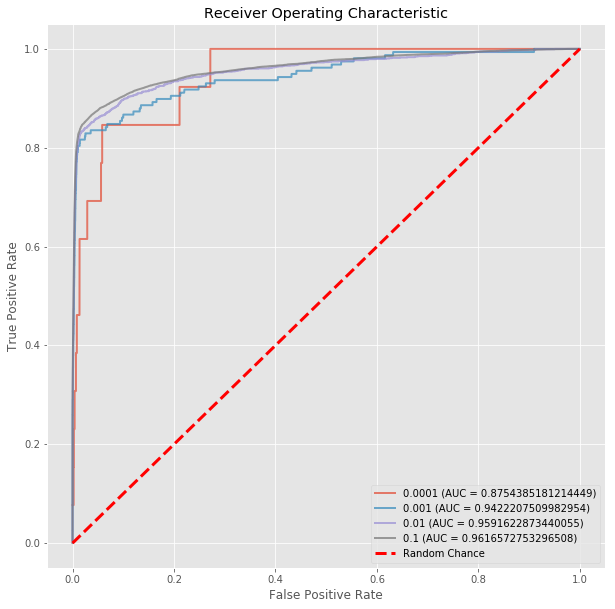

,Ratio,K-Fold(6) Mean AUC,False-Positive Rate,True-Positive Rate,Sample Size,SysTime
0,0.0001,0.875439,"[0.0, 0.002113821138211382, 0.0021138211382113...","[0.07692307692307693, 0.07692307692307693, 0.1...",18490,2018-04-26 20:02:41.487440
1,0.0010,0.942221,"[0.0, 0.0, 1.6266510508165787e-05, 1.626651050...","[0.006329113924050633, 0.02531645569620253, 0....",184904,2018-04-26 20:03:10.283292
2,0.0100,0.959162,"[0.0, 0.0, 1.6264155914704261e-06, 1.626415591...","[0.0006684491978609625, 0.004010695187165776, ...",1849039,2018-04-26 20:03:54.357492
3,0.1000,0.961657,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00019683747785578375, 0.0008529624040417295...",18490389,2018-04-26 20:07:52.713021


time: 5min 37s


In [14]:
train_eval_plot(train=train, targetFeature='is_attributed', ratios=[0.0001,0.001,0.01,0.1])